# Two States with bit flip errors.
In this protocol we will introduce some bil flip errors in the sending process.

In [1]:


# import all necessary objects and methods for quantum circuits
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, assemble
from qiskit.quantum_info import Operator
from qiskit.circuit import Parameter
from qiskit.qasm3 import dumps
from qiskit_ibm_runtime import Sampler
from qiskit.compiler import transpile
from qiskit_aer import Aer
from random import randrange
from qiskit.primitives import BackendSampler
import hashlib 

def print_outcomes_in_reserve(counts): # takes a dictionary variable
    for outcome in counts: # for each key-value in dictionary
        reverse_outcome = ''
        for i in outcome: # each string can be considered as a list of characters
            reverse_outcome = i + reverse_outcome # each new symbol comes before the old symbol(s)
    return reverse_outcome

#Source for SendState: awards/teach_me_qiskit_2018/cryptography/Cryptography.ipynb

def NoisyChannel(qc1, qc2, qc1_name):
    ''' This function takes the output of a circuit qc1 (made up only of x and 
        h gates, simulate noisy quantum channel, where Pauli errors (X - bit flip; Z - phase flip
        will occur in qc2 and then initializes another circuit qc2 with introduce noise.
    ''' 
    
    # Quantum state is retrieved from qasm code of qc1
    qs = dumps(qc1).split(sep=';')[4:-1]
    print(qs)

    # Process the code to get the instructions
    for index, instruction in enumerate(qs):
        qs[index] = instruction.lstrip()

    
     # Parse the instructions and apply to new circuit
    for instruction in qs:
        if instruction[0] == 'x':
            if instruction[5] == '[':
                
                old_qr = int(instruction[6:-1])
            else:
                old_qr = int(instruction[5:-1])
            qc2.h(qreg[old_qr])
        
        elif instruction[0] == 'h':
            if instruction[5] == '[':
                old_qr = int(instruction[6:-1])
            else:
                old_qr = int(instruction[5:-1])
            qc2.x(qreg[old_qr])             
        elif instruction[0] == 'm': # exclude measuring:
            pass
            
              
        else:
            raise Exception(f"Unable to parse instruction: {instruction}")

        

qreg = QuantumRegister(24) # quantum register with 8 qubits
creg = ClassicalRegister(24) # classical register with 8 bits

# Quantum circuit for Asja state
asja = QuantumCircuit(qreg, creg, name='Asja')

send=[] #Initial bit string to send
balvis_basis=[]
asja_basis=[]

#Creating random bit string
for i in range(24):
    bit = randrange(2)
    send.append(bit)
print("The bits Asja wants to send:     ",send)

asja_basis = ['X' if x==1 else "Z" if x==0  else x for x in send]
print("Asja Basis:        ",asja_basis)

for i in range(24):
    a_b = randrange(2)
    balvis_basis.append(a_b)
balvis_basis = ['X' if x==1 else "Z" if x==0  else x for x in balvis_basis]
print("Balvis Basis:        ",balvis_basis)








    


: 

Asja prepare the state for sending.

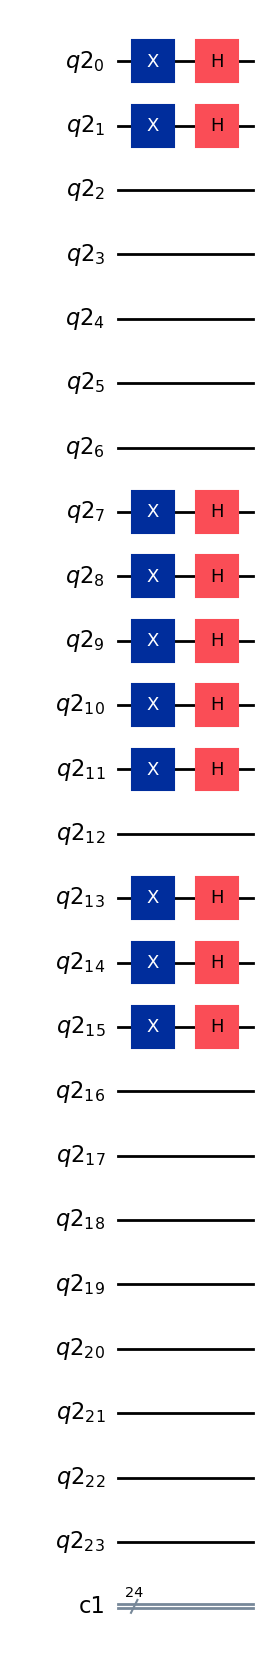

In [ ]:
#Apply X gate if bit is equal to 1

for i, n in enumerate(send):
    if n==1:
        asja.x(qreg[i]) # apply x-gate
        asja.h(qreg[i])
    send_str = ''.join(str(e) for e in send)


asja.draw("mpl") #To check gates applied correctly

Balvis measures the states.

In [ ]:
balvis = QuantumCircuit(qreg, creg, name='Balvis') #Defining Balvis circuit
NoisyChannel(asja, balvis, 'Asja') #Asja sends states to Balvis
for i, k in enumerate(balvis_basis): 
    if k=='X':
        balvis.h(qreg[i])


balvis.draw("mpl")



balvis.measure(qreg, creg)


job = assemble(balvis)
result = Aer.get_backend('qasm_simulator').run(job).result()
counts = result.get_counts(balvis)
received = print_outcomes_in_reserve(counts)

print("Asja sent:", send_str)
print("Balvis received:", received)


['\nx q2[0]', '\nh q2[0]', '\nx q2[1]', '\nh q2[1]', '\nx q2[7]', '\nh q2[7]', '\nx q2[8]', '\nh q2[8]', '\nx q2[9]', '\nh q2[9]', '\nx q2[10]', '\nh q2[10]', '\nx q2[11]', '\nh q2[11]', '\nx q2[13]', '\nh q2[13]', '\nx q2[14]', '\nh q2[14]', '\nx q2[15]', '\nh q2[15]']
Asja sent: 110000011111011100000000
Balvis received: 000000011110001001000010


C:\Users\dell\AppData\Local\Temp\ipykernel_12156\3325978102.py:16: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  result = Aer.get_backend('qasm_simulator').run(job).result()


The sifted key both Asja and Balvis will keep.

In [ ]:
asja_key=[] #Asjas register for matching rounds
balvis_key=[] #Balvis register for matching rounds
for j in range(0,len(asja_basis)): #Going through list of bases 
    if asja_basis[j] == balvis_basis[j]: #Comparing
        asja_key.append(send[j])
        balvis_key.append(received[j]) #Keeping key bit if bases matched
    else:
        pass #Discard round if bases mismatched
balvis_key = [eval(i) for i in balvis_key]
print("Asjas key =", asja_key)
print("Balvis key =", balvis_key)

Asjas key = [1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0]
Balvis key = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Error Correction.

In [ ]:
rounds = len(asja_key)//3    #To divide without remainer, use //

errors=0
for i in range(rounds):
    bit_index = randrange(len(asja_key)) 
    
    tested_bit = asja_key[bit_index]
    print ("Asja randomly selected bit index =", bit_index, ", and its value is = ", tested_bit)
    if asja_key[bit_index]!=balvis_key[bit_index]: #comparing tested rounds
        errors=errors+1 #calculating errors
    #removing tested bits from key strings
    del asja_key[bit_index] #Use del to specify the index of the element you want to delete
    del balvis_key[bit_index]
if rounds!=0:
    QBER=errors/rounds #calculating QBER
else:
    print("the key is too short for privacy amplification ")       
print("QBER value =", QBER)
print("Asjas secret key =", asja_key)
print("Balvis secret key =", balvis_key)
print("Number of errors = ", errors)


Asja randomly selected bit index = 7 , and its value is =  0
Asja randomly selected bit index = 7 , and its value is =  0
Asja randomly selected bit index = 0 , and its value is =  1
Asja randomly selected bit index = 3 , and its value is =  1
QBER value = 0.5
Asjas secret key = [0, 1, 0, 1, 0, 0, 0, 0]
Balvis secret key = [0, 0, 0, 0, 0, 0, 0, 0]
Number of errors =  2


Privacy Amplification.

In [ ]:
remain_key_asja = asja_key
remain_key_balvis = balvis_key
#Generating seed (salt)
seed=[]
for i in remain_key_asja:
    a=randrange(2)
    seed.append(a)

#Adding seeds to the keys
remain_key_asja.append(seed)
remain_key_balvis.append(seed)
 

#Converting lists to strings
str_key_asja = ' '.join([str(elem) for elem in remain_key_asja])
str_key_balvis = ' '.join([str(elem) for elem in remain_key_balvis])

#checking first bit to decide hash function to use
if remain_key_asja[0]==0:
    result=hashlib.sha256(str_key_asja.encode())
    print("Encoded using SHA256:", result.hexdigest())
else:
    result=hashlib.sha3_256(str_key_asja.encode())
    print("Encoded using SHA3 256:", result.hexdigest())
bin(int(result.hexdigest(), 16))[2:]